Noise Types:
- pr: POS-guided word replacement
- sr: synonym replacement
- ri: random insertion
- rs: random swap
- rd: random deletion

In [145]:
import matplotlib.pyplot as plt
import json
from collections import OrderedDict
import seaborn as sns
import pandas as pd
import numpy as np
import os

from matplotlib.ticker import StrMethodFormatter

from scipy.stats import entropy

SAVE_PLOTS = False

image_save_path = 'plots/robustness_study'
os.makedirs(image_save_path, exist_ok=True)

In [146]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "serif"

In [147]:

def map_noise_type(noise_type):
    mapping = {
        'psr': 'Synonym Replacement',
        'ppr': 'POS-Tag Replacement',
        'pri': 'Random Insertion',
        'prs': 'Random Swap',
        'prd': 'Random Deletion'
    }
    return mapping[noise_type]

In [148]:
with open('../out/robustness_study/results_bert_teacher.json', 'r') as f:
    results_bert_teacher = json.load(f)
with open('../out/robustness_study/results_bert_student.json', 'r') as f:
    results_bert_student = json.load(f)

from src.utils.metrics import ece_score_l1
# recompute ece with ece_l1 for all noise types
for noise_type in results_bert_teacher:
    for level in results_bert_teacher[noise_type]:
        results_bert_teacher[noise_type][level]['ece_score'] = ece_score_l1(np.array(results_bert_teacher[noise_type][level]['y_true']), np.array(results_bert_teacher[noise_type][level]['y_pred']), np.array(results_bert_teacher[noise_type][level]['y_prob']))

for noise_type in results_bert_student:
    for level in results_bert_student[noise_type]:
        results_bert_student[noise_type][level]['ece_score'] = ece_score_l1(np.array(results_bert_student[noise_type][level]['y_true']), np.array(results_bert_student[noise_type][level]['y_pred']), np.array(results_bert_student[noise_type][level]['y_prob']))
        

In [149]:
def plot_noise_type_f1_vs_ece(noise_type: str):   
    levels = sorted(results_bert_teacher[noise_type].keys())
    f1_scores_teacher = [results_bert_teacher[noise_type][level]['f1_score'] for level in levels]
    f1_scores_student = [results_bert_student[noise_type][level]['f1_score'] for level in levels]
    ece_scores_teacher = [results_bert_teacher[noise_type][level]['ece_score'] for level in levels]
    ece_scores_student = [results_bert_student[noise_type][level]['ece_score'] for level in levels]
    
    # add std dev candles
    f1_scores_teacher_std = [results_bert_teacher[noise_type][level]['f1_score_std'] for level in levels]
    f1_scores_student_std = [results_bert_student[noise_type][level]['f1_score_std'] for level in levels]
    ece_scores_teacher_std = [results_bert_teacher[noise_type][level]['ece_score_std'] for level in levels]
    ece_scores_student_std = [results_bert_student[noise_type][level]['ece_score_std'] for level in levels]
    
    # confidence intervals
    t = 1.96
    f1_scores_teacher_std = [t * std for std in f1_scores_teacher_std]
    f1_scores_student_std = [t * std for std in f1_scores_student_std]
    ece_scores_teacher_std = [t * std for std in ece_scores_teacher_std]
    ece_scores_student_std = [t * std for std in ece_scores_student_std]
    
    fig, ax1 = plt.subplots(figsize=(10, 8))
    
    # F1 Scores
    ax1.set_xlabel('Noise Level')
    ax1.set_ylabel('F1 Score', color='tab:blue')
    ax1.plot(levels, f1_scores_teacher, label='Teacher F1 Score', marker='o', color='tab:blue', lw=3)
    ax1.plot(levels, f1_scores_student, label='Student F1 Score', marker='x', linestyle='--', color='tab:blue', lw=3)
    # ax1.set_ylim(0, 1)
    # plot confidence intervals as area around the line
    ax1.fill_between(levels, [f1 - std for f1, std in zip(f1_scores_teacher, f1_scores_teacher_std)], [f1 + std for f1, std in zip(f1_scores_teacher, f1_scores_teacher_std)], color='tab:blue', alpha=0.2)
    ax1.fill_between(levels, [f1 - std for f1, std in zip(f1_scores_student, f1_scores_student_std)], [f1 + std for f1, std in zip(f1_scores_student, f1_scores_student_std)], color='tab:blue', alpha=0.2)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    ax2.set_ylabel('ECE', color='tab:red')  # we already handled the x-label with ax1
    ax2.plot(levels, ece_scores_teacher, label='Teacher ECE', marker='o', color='tab:red', lw=3)
    ax2.plot(levels, ece_scores_student, label='Student ECE', marker='x', linestyle='--', color='tab:red', lw=3)
    # plot confidence intervals as area around the line
    ax2.fill_between(levels, [ece - std for ece, std in zip(ece_scores_teacher, ece_scores_teacher_std)], [ece + std for ece, std in zip(ece_scores_teacher, ece_scores_teacher_std)], color='tab:red', alpha=0.2)
    ax2.fill_between(levels, [ece - std for ece, std in zip(ece_scores_student, ece_scores_student_std)], [ece + std for ece, std in zip(ece_scores_student, ece_scores_student_std)], color='tab:red', alpha=0.2)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    
    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    # plt.title(f'Performance Comparison for {map_noise_type(noise_type)}')
    if SAVE_PLOTS:
        plt.tight_layout()
        plt.savefig(os.path.join(image_save_path, f"plot_{noise_type}_f1_ece.pdf"))
        plt.close()

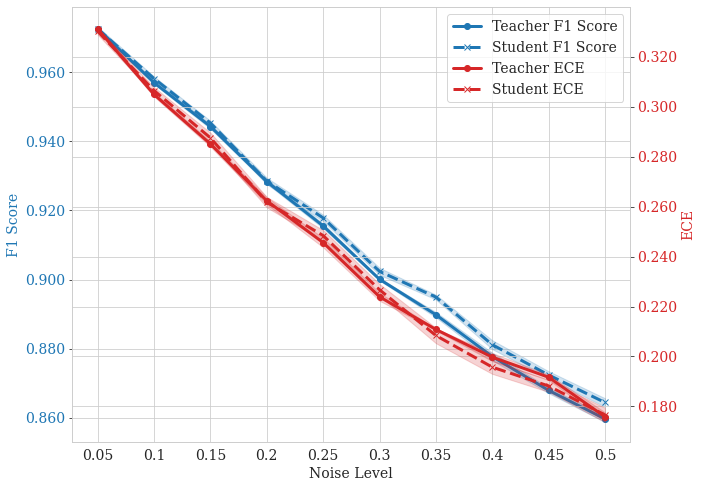

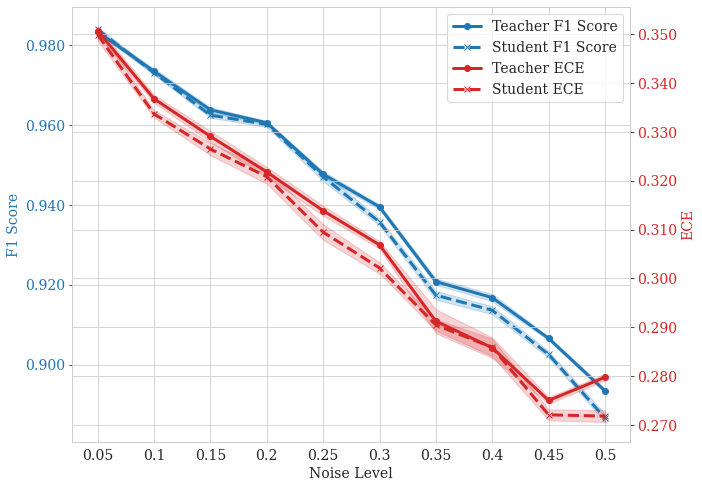

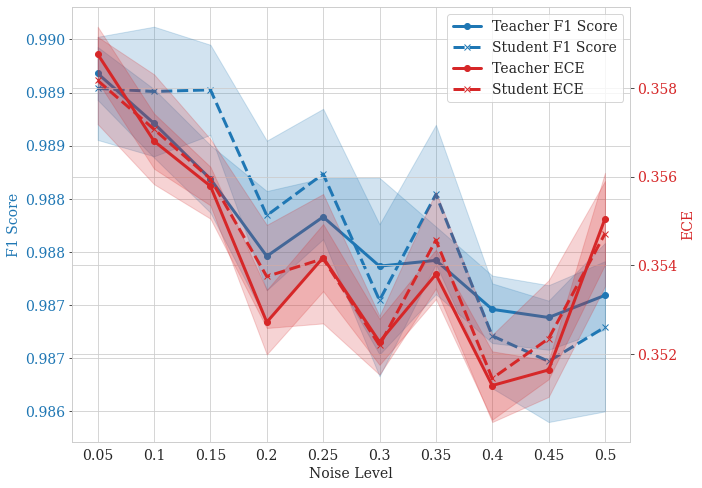

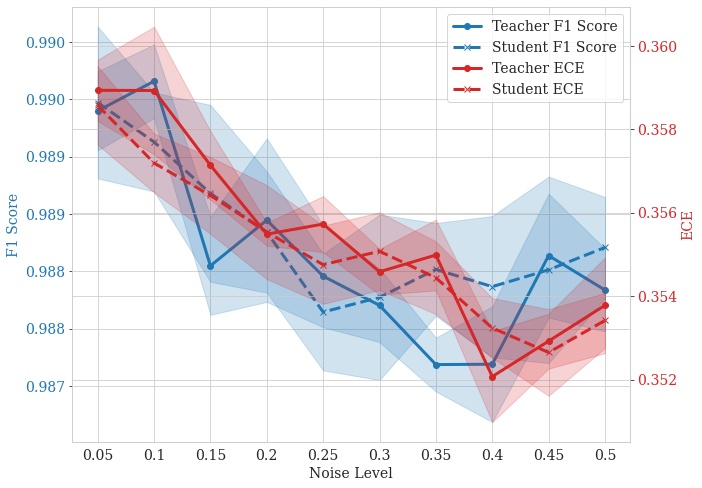

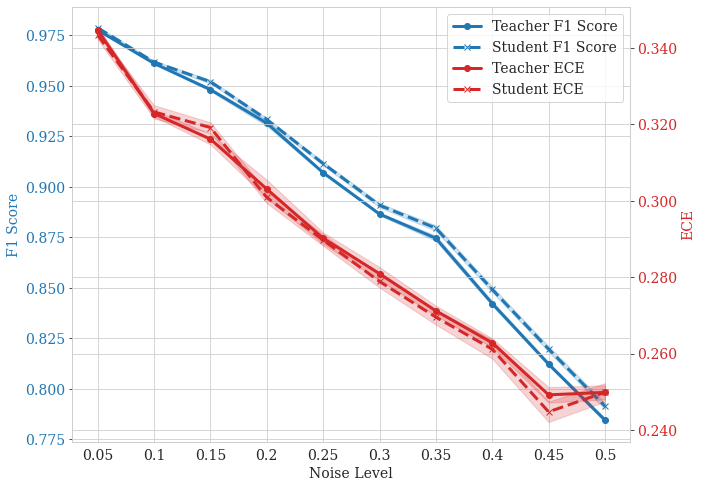

In [150]:
# custom order of keys - natural to synthetic noise types: pr, sr, ri, rs, rd
keyorder = ['ppr', 'psr', 'pri', 'prs', 'prd']
for noise_type in OrderedDict(sorted(results_bert_teacher.items(), key=lambda i:keyorder.index(i[0]))):
    plot_noise_type_f1_vs_ece(noise_type)

- analyze further, especially after averaging over multiple runs
- see if teacher outperforms student anywhere 
-> if not, then uncertainty distillation was already complete success
-> if yes, then we can use the respective noise type to augment the transfer dataset and retrain the student, hoping for better performance

- random swap / random insertion patterns maybe due to artifacts in the perturbed data (given that random insertion especially can lead to nonsensical sentences) and random swap can heavily change the meaning of a sentence in some instances (look for examples)

- first idea, also looking at brier score vs f1 below: use light random swap and random insertion (prob 0.1) as augmentations
- here, teacher outperforms student in terms of predictive performance (f1), as well as in terms of calibration (brier score, ECE)
--> confirm with new results

**POS-tag replacement**
- student significantly outperforms teacher in terms of f1 score for higher noise levels
- no significant difference in uncertainty quality (ECE score) between teacher and student
- student has significantly lower brier score for higher noise levels

**Synonym replacement**
- teacher performs significantly better in terms of predictive performance (f1) than student, gap increases with noise level
- ECE (uncertainty quality) tends to be equal to teacher or slightly lower (better) for student across all noise levels
- brier score is significantly higher for student across almost all noise levels

**Random insertion**
- f1 and ECE ranges are very small
- unclear pattern, no model significantly outperforms the other in terms of predictive performance (f1)
- similar for uncertainty quality
- student tends to exhibit higher brier score (worse calibration), but not always significantly

**Random swap**
- f1 and ECE ranges are very small
- student has slightly higher f1 for greater levels of noise, not always significantly
- ECE tends to be the same for both models
- slightly lower brier score for student, not (significantly) throughout all noise levels

**Random deletion**
- student significantly outperforms teacher in terms of predictive performance (f1), gap increases with noise level
- ECE lower for student, but no significant difference for most noise levels
- calibration (uncertainty quality) tends to be slightly better for student across higher noise levels, but not significantly


##### Conclusion
- POS-tag replacement: student has better performance, better calibration (Brier score), similar uncertainty quality to teacher
- Synonym replacement: student has worse performance, worse calibration (Brier score), better uncertainty quality to teacher
- Random insertion: no clear pattern, but student tends to have worse calibration (Brier score)
- Random swap: student has slightly better performance, marginally better calibration (Brier score), similar uncertainty quality to teacher
- Random deletion: student has better performance, slightly better calibration (Brier score), similar but slightly better uncertainty quality to teacher

We hence observe a general trend of the student outperforming the teacher in terms of predictive performance, as measured by the F1 score, and an overall better uncertainty quality in terms of the ECE score. The student's calibration, as measured by the Brier score, is also on average equal to or slightly better than the teacher's. This suggests that the uncertainty distillation was successful, and the student model is more robust to noisy data than the teacher model.
 
However, we do not observe a consistent pattern across all noise types. While for POS-tag replacement and random deletion, the student model outperforms the teacher model in terms of predictive performance and calibration, for synonym replacement and random swap, the student model tends to have worse performance and calibration. Random insertion does not show a clear pattern, but the student model tends to have worse calibration. 

This suggests that the student model might benefit from augmenting the uncertainty distillation transfer training data with the noise types where it struggles compared to the teacher model. While the difference in performance and calibration is relatively small for the random swap noise type, we include it as a representation of a synthetic augmentation.

Specifically, we propose to lightly augment the transfer dataset with random swap and synonym replacement noise. We will then retrain the student model on this augmented transfer dataset and evaluate its performance on the test set. We expect that this new student model will exhibit better performance and calibration on the test set, as it will have been trained on a more diverse set of data, including the noise types that it previously struggled with compared to the teacher model, leading to a more robust model overall.

In [130]:
def plot_noise_type_f1_vs_brier(noise_type: str):    
    levels = sorted(results_bert_teacher[noise_type].keys())
    f1_scores_teacher = [results_bert_teacher[noise_type][level]['f1_score'] for level in levels]
    f1_scores_student = [results_bert_student[noise_type][level]['f1_score'] for level in levels]
    brier_scores_teacher = [results_bert_teacher[noise_type][level]['brier_score'] for level in levels]
    brier_scores_student = [results_bert_student[noise_type][level]['brier_score'] for level in levels]
    
    # add std dev candles
    f1_scores_teacher_std = [results_bert_teacher[noise_type][level]['f1_score_std'] for level in levels]
    f1_scores_student_std = [results_bert_student[noise_type][level]['f1_score_std'] for level in levels]
    brier_scores_teacher_std = [results_bert_teacher[noise_type][level]['brier_score_std'] for level in levels]
    brier_scores_student_std = [results_bert_student[noise_type][level]['brier_score_std'] for level in levels]
    
    # confidence intervals
    t = 1.96
    f1_scores_teacher_std = [t * std for std in f1_scores_teacher_std]
    f1_scores_student_std = [t * std for std in f1_scores_student_std]
    brier_scores_teacher_std = [t * std for std in brier_scores_teacher_std]
    brier_scores_student_std = [t * std for std in brier_scores_student_std]
    
    fig, ax1 = plt.subplots(figsize=(10, 8))
    
    # F1 Scores
    ax1.set_xlabel('Noise Level')
    ax1.set_ylabel('F1 Score', color='tab:blue')
    ax1.plot(levels, f1_scores_teacher, label='Teacher F1 Score', marker='o', color='tab:blue', lw=3)
    ax1.plot(levels, f1_scores_student, label='Student F1 Score', marker='x', linestyle='--', color='tab:blue', lw=3)
    # plot confidence intervals as area around the line
    ax1.fill_between(levels, [f1 - std for f1, std in zip(f1_scores_teacher, f1_scores_teacher_std)], [f1 + std for f1, std in zip(f1_scores_teacher, f1_scores_teacher_std)], color='tab:blue', alpha=0.2)
    ax1.fill_between(levels, [f1 - std for f1, std in zip(f1_scores_student, f1_scores_student_std)], [f1 + std for f1, std in zip(f1_scores_student, f1_scores_student_std)], color='tab:blue', alpha=0.2)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    
    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Brier Score', color='tab:red')  # we already handled the x-label with ax1
    ax2.plot(levels, brier_scores_teacher, label='Teacher Brier Score', marker='o', color='tab:red', lw=3)
    ax2.plot(levels, brier_scores_student, label='Student Brier Score', marker='x', linestyle='--', color='tab:red', lw=3)
    # plot confidence intervals as area around the line
    ax2.fill_between(levels, [brier - std for brier, std in zip(brier_scores_teacher, brier_scores_teacher_std)], [brier + std for brier, std in zip(brier_scores_teacher, brier_scores_teacher_std)], color='tab:red', alpha=0.2)
    ax2.fill_between(levels, [brier - std for brier, std in zip(brier_scores_student, brier_scores_student_std)], [brier + std for brier, std in zip(brier_scores_student, brier_scores_student_std)], color='tab:red', alpha=0.2)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center left')
    
    # plt.title(f'Performance Comparison for {map_noise_type(noise_type)}')
    if SAVE_PLOTS:
        plt.tight_layout()
        plt.savefig(os.path.join(image_save_path, f"plot_{noise_type}_f1_brier.pdf"))
        plt.close()

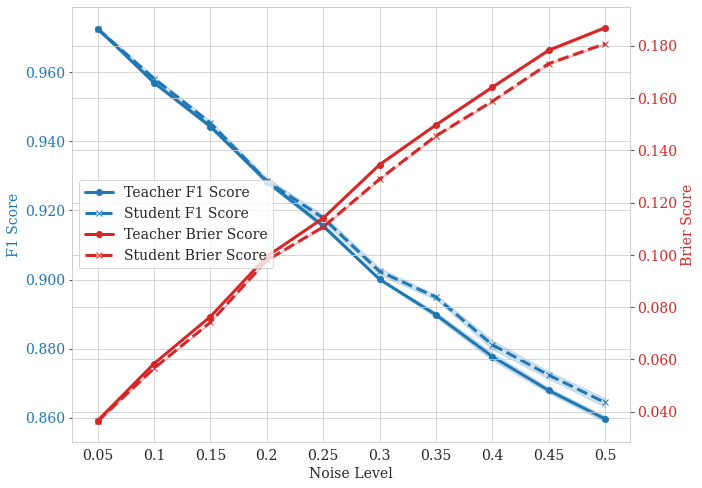

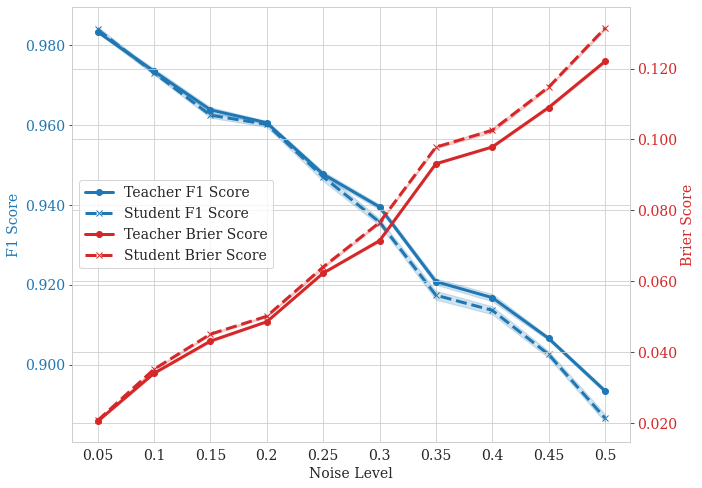

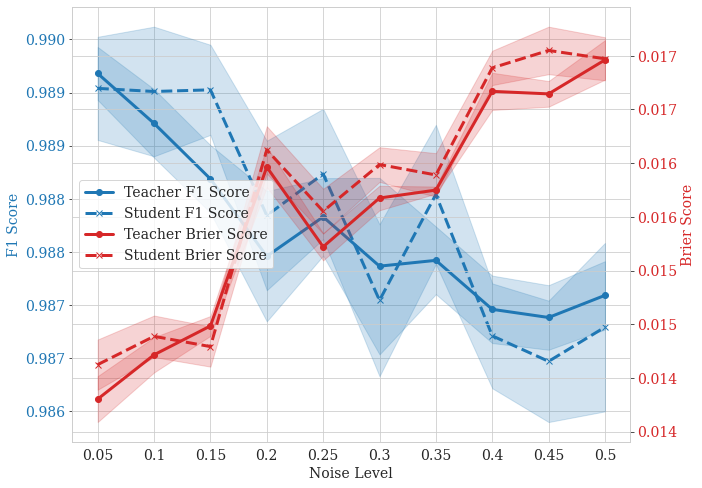

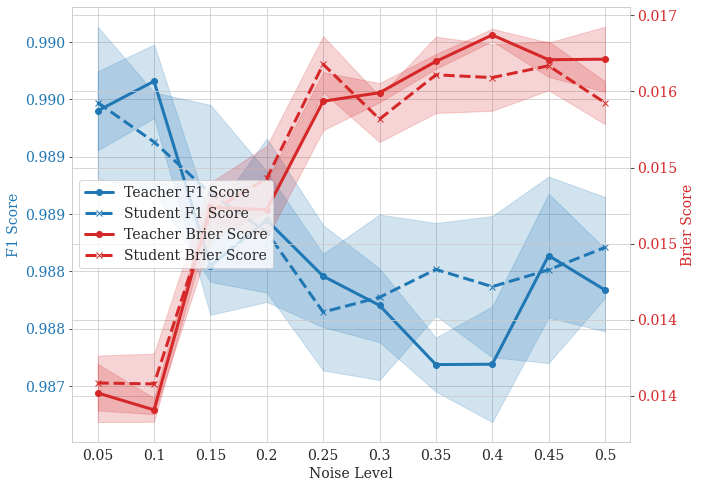

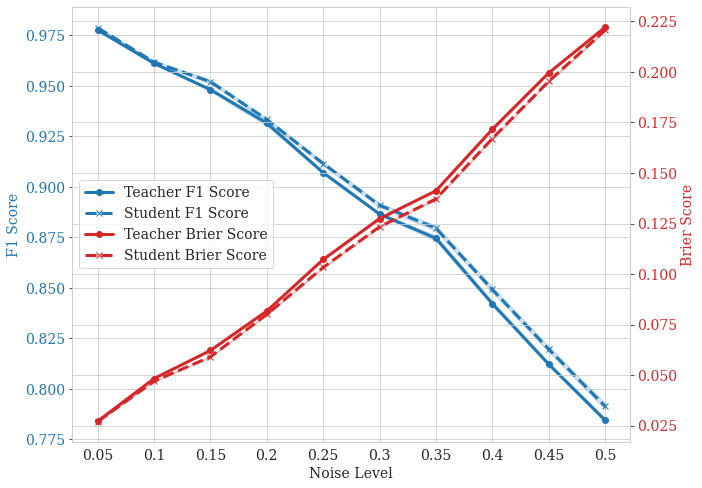

In [131]:
keyorder = ['ppr', 'psr', 'pri', 'prs', 'prd']
for noise_type in OrderedDict(sorted(results_bert_teacher.items(), key=lambda i:keyorder.index(i[0]))):
    plot_noise_type_f1_vs_brier(noise_type)

#### Visualize predictive distribution

In [119]:
def plot_predictive_distribution(results: dict, noise_type: str):
    levels = sorted(results[noise_type].keys())
    
    fig, ax = plt.subplots(figsize=(10, 8))
    for level in levels:
        predictive_distribution = results[noise_type][level]['y_prob']
        sns.kdeplot(predictive_distribution, label=f'Noise Level {level}', clip=[0, 1], fill=True, ax=ax)
    plt.title(f'Predictive Distribution for {map_noise_type(noise_type)}')
    plt.legend(loc='upper left')
    plt.show()

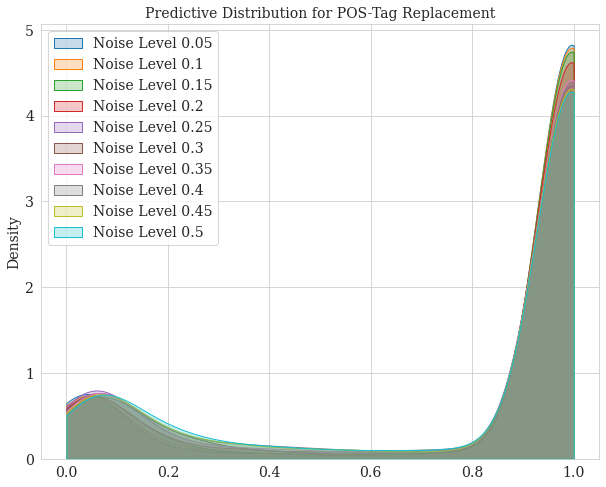

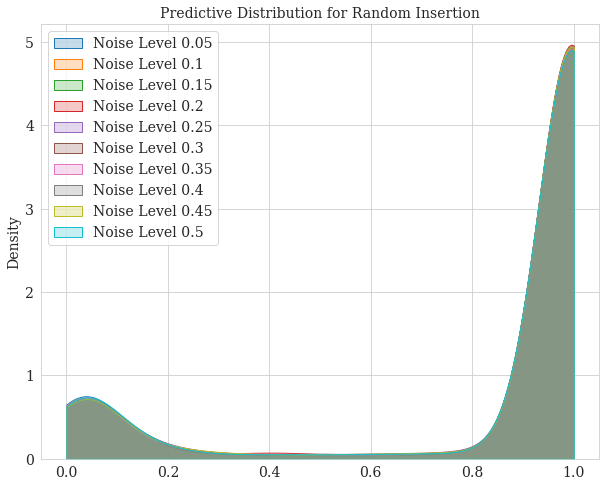

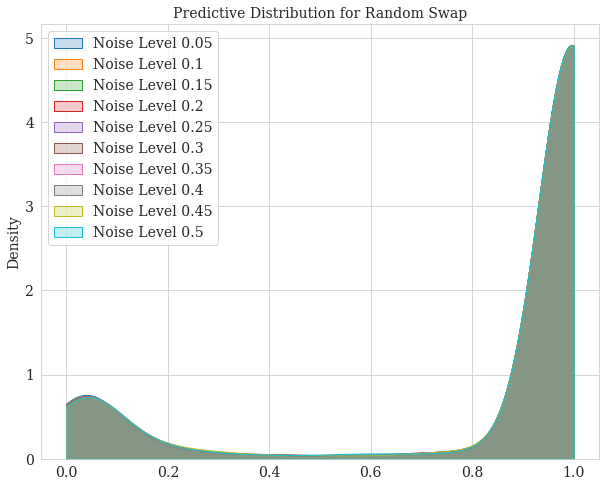

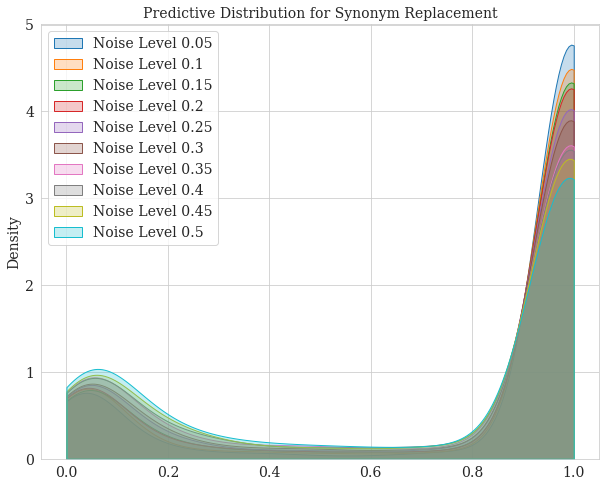

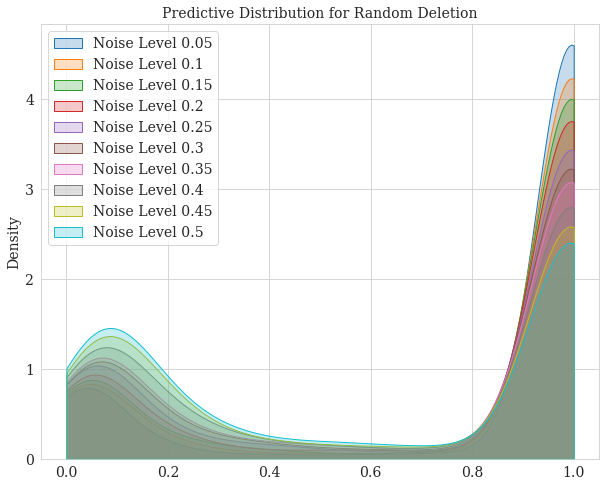

In [120]:
for noise_type in results_bert_teacher.keys():
    plot_predictive_distribution(results_bert_teacher, noise_type)
    
# results look very similar for bert student

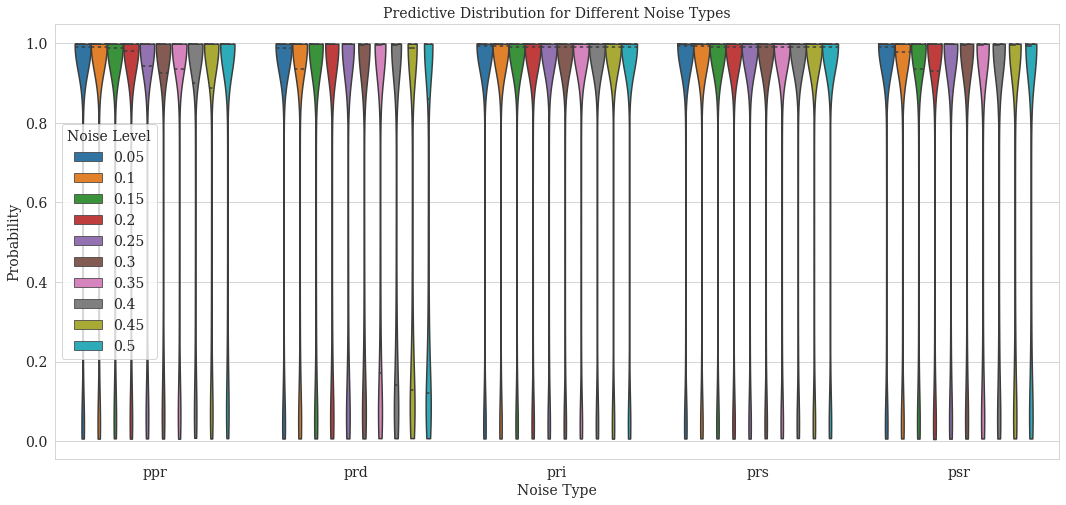

In [121]:
# Assuming 'results' is structured appropriately
# You might need to reshape your data into a 'long' format for these plots
data = []
for noise_type, levels in results_bert_teacher.items():
    for level, stats in levels.items():
        for prob in stats['y_prob']:
            data.append({'Noise Type': noise_type, 'Noise Level': level, 'Probability': prob})

df = pd.DataFrame(data)
# sort by noise level ascending for each noise type
df = df.sort_values(by=['Noise Type', 'Noise Level'])

plt.figure(figsize=(18, 8))
# plot violinplots but noise levels grouped together for each noise type, sort by noise level ascending
sns.violinplot(data=df, x='Noise Type', y='Probability', hue='Noise Level', inner='quart', cut=0, linewidth=1.5)
plt.title('Predictive Distribution for Different Noise Types');

#### Average entropy as measure of peakedness of test set predictive distribution
https://mathoverflow.net/questions/15326/peakedness-of-multimodal-distributions

In [122]:

fig, ax = plt.subplots(figsize=(10, 8))

color_map = plt.cm.get_cmap('tab10', len(keyorder))
colors = {key: color_map(i) for i, key in enumerate(keyorder)}

keyorder = ['ppr', 'psr', 'pri', 'prs', 'prd']

for i, (noise_type, _) in enumerate(OrderedDict(sorted(results_bert_teacher.items(), key=lambda i:keyorder.index(i[0]))).items()):
    levels = sorted(results_bert_teacher[noise_type].keys())
    entropies_teacher = [np.mean([entropy([p, 1-p]) for p in level_probs]) for level_probs in [results_bert_teacher[noise_type][level]['y_prob'] for level in levels]]
    entropies_student = [np.mean([entropy([p, 1-p]) for p in level_probs]) for level_probs in [results_bert_student[noise_type][level]['y_prob'] for level in levels]]
    ax.plot(levels, entropies_teacher, marker='o', color=colors[noise_type], lw=3, label=f"{map_noise_type(noise_type)} Teacher" if i == 0 else "")
    ax.plot(levels, entropies_student, marker='x', linestyle='--', color=colors[noise_type], lw=3, label=f"{map_noise_type(noise_type)} Student" if i == 0 else "")

ax.set_xlabel('Noise Level')
ax.set_ylabel('Average Entropy')
# ax.set_title('Average Entropy of Predictive Distribution')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=3, marker='o'),
                Line2D([0], [0], color='black', lw=3, marker='x', linestyle='--')]

custom_lines += [Line2D([0], [0], color=colors[noise_type], lw=3) for noise_type in keyorder]

ax.legend(custom_lines, ['Teacher', 'Student', *map(map_noise_type, keyorder)])

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

if SAVE_PLOTS:
    plt.tight_layout()
    plt.savefig(os.path.join(image_save_path, f"plot_noise_type_average_entropy.pdf"))
    plt.close()

- plots (entropy vs noise level and predictive distributions for noise types) confirm that the predictive distribution becomes less peaked (higher entropy) with increasing noise level, but not for all noise levels
- in fact, only where the ECE decreases with increasing noise level do we observe an increase in entropy / a less peaked predictive distribution for greater levels of noise
- for random swap and random insertion, the ECE decrease is far less pronounced and not even necessarily statistically significant 
- this is also reflected in the entropy plots, where the entropy does not greatly increase with increasing noise level for these noise types / the predictive distribution stays approximately the same (relatively peaked)


- in line with explanation offered in /Users/johann/Documents/Research Setup/Thesis - Uncertainty in Deep Learning/Notes/Real-Time UQ for Text Classification/Paper Notes/6 Results/Robustness study result analysis.md to explain difference between behavior of ECE and Brier Score

"The observation of increasing entropy in your predictive distributions alongside a decrease in the Expected Calibration Error (ECE) can indeed occur under certain conditions, and understanding this requires a closer look at what these metrics represent in the context of probabilistic predictions and model calibration, especially with your ECE implementation in mind.
Entropy and Its Significance

Entropy, in the context of predictive distributions, measures the uncertainty or disorder within these distributions. A higher entropy value indicates a more uniform distribution (less peakedness), suggesting that the model is less certain about its predictions. In contrast, lower entropy indicates more confidence (higher peakedness) as the model assigns higher probability to specific outcomes.
Expected Calibration Error (ECE)

Your ECE implementation measures the calibration of the model, specifically the agreement between predicted probabilities and observed outcomes across different bins. A lower ECE suggests that the predicted probabilities are, on average, closer to the true outcome frequencies within each bin.
Connecting Entropy with Decreased ECE

The connection between increasing entropy (reduced peakedness) and decreasing ECE in the context of increasing noise can be explained as follows:

    Model's Response to Noise: As noise increases, a well-regularized model might respond by becoming more conservative in its predictions, leading to a broader distribution of predicted probabilities (increased entropy). This means rather than being overly confident about uncertain outcomes (predicting probabilities close to 0 or 1), the model starts predicting probabilities that are more spread out, indicating uncertainty.

    Improved Calibration: This increase in entropy or reduction in peakedness can lead to improved calibration (lower ECE) for a key reason: by acknowledging uncertainty and spreading probabilities across a wider range, the model's predicted probabilities can become more aligned with the actual outcome frequencies. For example, if the true outcome is uncertain due to noise, a prediction with moderate confidence (probabilities closer to 0.5 for binary classification) might more accurately reflect the likelihood of the observed outcomes than a high-confidence prediction.

    Calibration vs. Confidence: The decrease in ECE in this scenario suggests that the model's probability predictions are becoming better calibrated to the true frequencies of outcomes. Essentially, the model is correctly estimating its uncertainty. This is desirable in noisy environments, where distinguishing between classes becomes harder.

Summary

    Increasing Noise leads to Higher Entropy in predictive distributions as the model becomes more uncertain, spreading its predictions rather than concentrating them.
    This Higher Entropy can coincide with Lower ECE because the model's predictions are becoming more aligned with the true distribution of outcomes, indicating better calibration.
    The decrease in ECE, given this context, is a sign that the model is effectively adjusting its confidence levels to match the observed data's uncertainty, which is a positive outcome for model reliability, especially in noisy or uncertain environments.

Your observation underscores the nuanced relationship between model calibration, confidence, and uncertainty in predictive modeling, highlighting the importance of considering these aspects when evaluating model performance."